In [3]:
import os
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt 

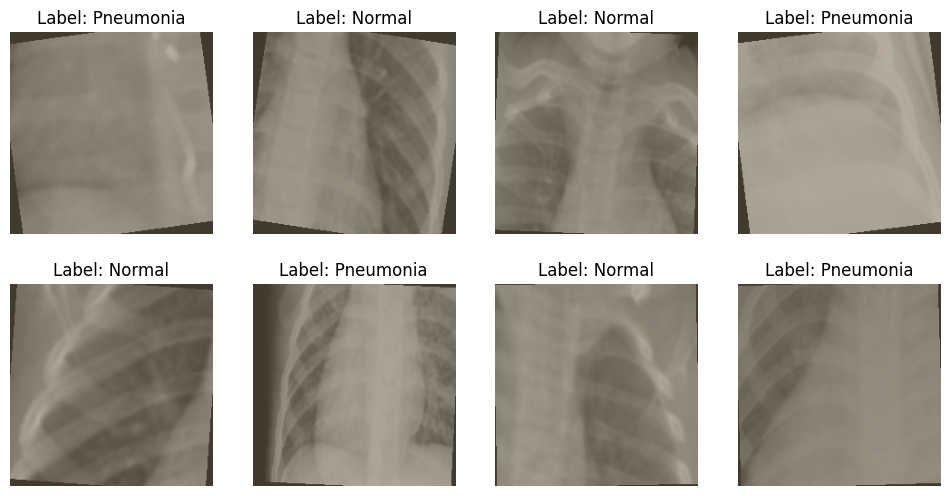

In [4]:
data_dir = r"chest_xray"
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')
val_dir = os.path.join(data_dir, 'val')
train_transforms = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5],
                         std=[0.5,0.5,0.5])
])

val_trasnforms =transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5],
                         std=[0.5,0.5,0.5])
])
class ChestXrayDataset(Dataset):
    def __init__(self, root_dir, transform):
        self.root_dir = root_dir
        self.transform =transform
        self.image_paths = []
        self.labels = []

        for label, class_name in enumerate(['NORMAL', 'PNEUMONIA']):
            class_dir = os.path.join(root_dir, class_name)
            for filename in os.listdir(class_dir):
                self.image_paths.append(os.path.join(class_dir, filename))
                self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, index):
        img_path = self.image_paths[index]
        image = Image.open(img_path).convert("RGB")
        label = self.labels[index]

        if self.transform:
            image = self.transform(image)

        return image, label

train_dataset = ChestXrayDataset(train_dir, transform=train_transforms)
val_dataset = ChestXrayDataset(val_dir, transform= val_trasnforms)
test_dataset = ChestXrayDataset(test_dir, transform= val_trasnforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
def imshow_tensor(img_tensor):
    img_tensor = img_tensor * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img_tensor = img_tensor + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    img_tensor = img_tensor.clamp(0, 1)
    npimg = img_tensor.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

for images, labels in train_loader:
    plt.figure(figsize=(12, 6))
    for i in range(8):
        plt.subplot(2, 4, i+1)
        imshow_tensor(images[i])
        plt.title("Label: " + ("Normal" if labels[i]==0 else "Pneumonia"))
    break


Task 2

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ChestXrayCNN(nn.Module):
    def __init__(self):
        super(ChestXrayCNN, self).__init__()

        # Convolutional Block 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        # Convolutional Block 2
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        # Convolutional Block 3
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        # Fully Connected Layers
        self.fc1 = nn.Linear(128 * 28 * 28, 512)  # after 3 maxpool layers (224 → 112 → 56 → 28)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 2)  # Binary classification: 2 classes

    def forward(self, x):
        # Conv Block 1
        x = self.conv1(x)
        x = F.relu(x)
        x = self.bn1(x)
        x = F.max_pool2d(x, 2)  # 224 → 112

        # Conv Block 2
        x = self.conv2(x)
        x = F.relu(x)
        x = self.bn2(x)
        x = F.max_pool2d(x, 2)  # 112 → 56

        # Conv Block 3
        x = self.conv3(x)
        x = F.relu(x)
        x = self.bn3(x)
        x = F.max_pool2d(x, 2)  # 56 → 28

        # Flatten
        x = x.view(x.size(0), -1)  # Flatten to (batch_size, 128*28*28)

        # FC layers
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x


model = ChestXrayCNN()
print(model)

# Try a dummy input to check output shape
dummy_input = torch.randn(1, 3, 224, 224)
output = model(dummy_input)
print("Output shape:", output.shape)  # Should be [1, 2]



ChestXrayCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=100352, out_features=512, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)
Output shape: torch.Size([1, 2])


# Task 3

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import numpy as np
import os


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ChestXrayCNN().to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=1e-4)

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)


In [8]:
import copy

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=20, patience=5):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    no_improve_epochs = 0

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 30)

        # Training Phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        total = 0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            train_correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss /= total
        train_acc = train_correct / total

        # Validation Phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_loss /= val_total
        val_acc = val_correct / val_total

        print(f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f}")
        print(f"Val   Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

        scheduler.step(val_loss)

        # Early stopping and checkpointing
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), "best_model.pth")
            print("🔽 Best model updated!")
            no_improve_epochs = 0
        else:
            no_improve_epochs += 1
            print(f"⚠️ No improvement for {no_improve_epochs} epochs")

        if no_improve_epochs >= patience:
            print("🛑 Early stopping")
            break

    print("\n✅ Training complete. Loading best model weights.")
    model.load_state_dict(best_model_wts)
    return model


In [9]:
trained_model = train_model(
    model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=5,
    patience=5
)



Epoch 1/5
------------------------------
Train Loss: 0.5607, Acc: 0.7951
Val   Loss: 1.0436, Acc: 0.5625
🔽 Best model updated!

Epoch 2/5
------------------------------
Train Loss: 0.3567, Acc: 0.8436
Val   Loss: 0.5079, Acc: 0.8125
🔽 Best model updated!

Epoch 3/5
------------------------------
Train Loss: 0.3431, Acc: 0.8554
Val   Loss: 0.5753, Acc: 0.6250
⚠️ No improvement for 1 epochs

Epoch 4/5
------------------------------
Train Loss: 0.3086, Acc: 0.8689
Val   Loss: 1.1027, Acc: 0.6250
⚠️ No improvement for 2 epochs

Epoch 5/5
------------------------------
Train Loss: 0.2989, Acc: 0.8771
Val   Loss: 0.8207, Acc: 0.6875
⚠️ No improvement for 3 epochs

✅ Training complete. Loading best model weights.


Task 4

In [10]:
import torch
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    roc_auc_score
)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


In [11]:
model = ChestXrayCNN()
model.load_state_dict(torch.load("best_model.pth"))
model.to(device)
model.eval()


ChestXrayCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=100352, out_features=512, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)

In [12]:
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)                    # raw logits
        probs = torch.softmax(outputs, dim=1)      # convert to probabilities
        _, preds = torch.max(probs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs[:, 1].cpu().numpy())  # probability of class 'Pneumonia'


In [13]:
print("Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=["Normal", "Pneumonia"]))


Classification Report:

              precision    recall  f1-score   support

      Normal       0.74      0.86      0.79       234
   Pneumonia       0.91      0.82      0.86       390

    accuracy                           0.83       624
   macro avg       0.82      0.84      0.83       624
weighted avg       0.84      0.83      0.83       624



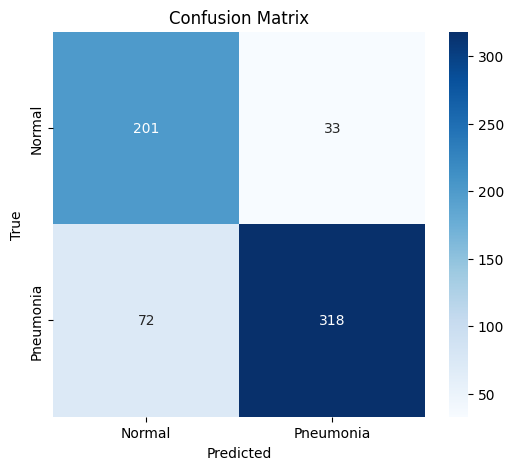

In [14]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Normal", "Pneumonia"], yticklabels=["Normal", "Pneumonia"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


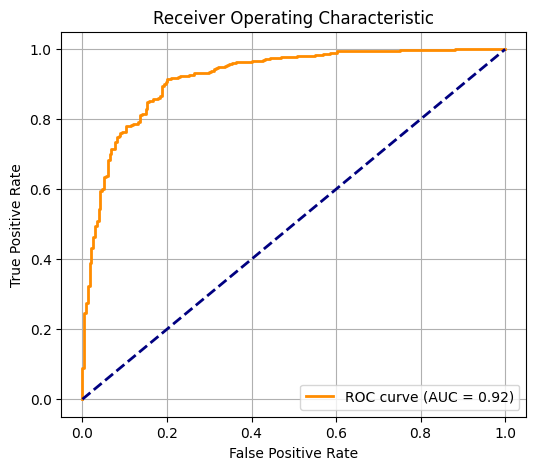

In [15]:
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
roc_auc = roc_auc_score(all_labels, all_probs)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


# Task 5

In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torchvision import transforms


In [17]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.model.eval()
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_handles = []
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()

        self.hook_handles.append(self.target_layer.register_forward_hook(forward_hook))
        self.hook_handles.append(self.target_layer.register_backward_hook(backward_hook))

    def remove_hooks(self):
        for handle in self.hook_handles:
            handle.remove()

    def generate(self, input_tensor, class_idx=None):
        output = self.model(input_tensor)

        if class_idx is None:
            class_idx = torch.argmax(output)

        # Zero grads + backward pass
        self.model.zero_grad()
        class_score = output[0, class_idx]
        class_score.backward()

        # Global average pooling over gradients
        weights = torch.mean(self.gradients, dim=(2, 3), keepdim=True)
        cam = torch.sum(weights * self.activations, dim=1).squeeze()

        # Normalize between 0 and 1
        cam = torch.clamp(cam, min=0)
        cam -= cam.min()
        cam /= cam.max()
        return cam.cpu().numpy()


In [18]:
def visualize_gradcam(model, image_tensor, original_image, class_names, layer_to_explain):
    grad_cam = GradCAM(model, layer_to_explain)
    cam = grad_cam.generate(image_tensor)
    grad_cam.remove_hooks()

    # Resize CAM to match input image
    cam = cv2.resize(cam, (original_image.shape[1], original_image.shape[0]))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    superimposed_img = heatmap * 0.4 + original_image

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(original_image)
    plt.title("Original Image")

    plt.subplot(1, 3, 2)
    plt.imshow(cam, cmap='jet')
    plt.title("Grad-CAM Heatmap")

    plt.subplot(1, 3, 3)
    plt.imshow(np.uint8(superimposed_img))
    plt.title("Superimposed")
    plt.show()


c:\Users\Hatif Neyaz\Desktop\practicing\vnv\Lib\site-packages\torch\nn\modules\module.py:1842: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


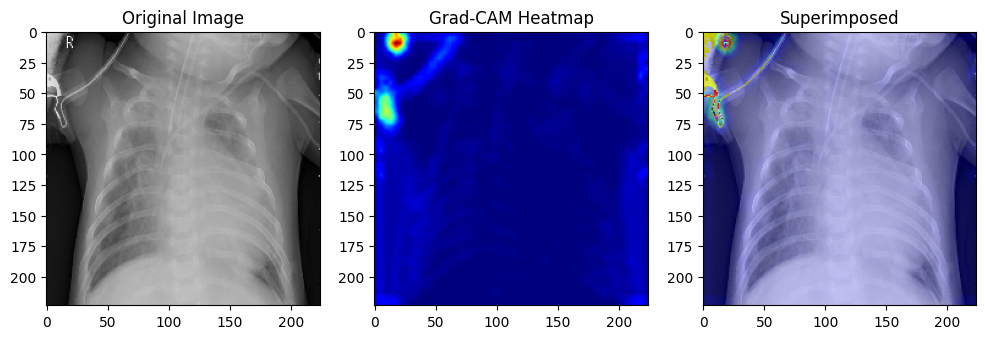

In [24]:
# Pick a test image
img_path = r"C:\Users\Hatif Neyaz\Desktop\practicing\Pneumonia\chest_xray\test\PNEUMONIA\person1_virus_6.jpeg"

# Load original image
original = cv2.imread(img_path)
original = cv2.resize(original, (224, 224))

# Transform into tensor (same as training)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

image_tensor = transform(original).unsqueeze(0).to(device)

# Run visualization
visualize_gradcam(
    model=model,
    image_tensor=image_tensor,
    original_image=original,
    class_names=["Normal", "Pneumonia"],
    layer_to_explain=model.conv3  # layer to visualize
)
